In [1]:
import math
import torch
import torchmetrics
import time
import numpy as np
import pandas as pd
import imageio.v3 as imageio
import albumentations as A
import torch.nn as nn

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
torch.manual_seed(3407)
np.random.seed(3407)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Define Classes

In [3]:
class Config():
    IMAGE_SIZE = 224
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 64
    LR_MAX = 1e-3
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 7
    TRAIN_MODEL = True
    IS_INTERACTIVE = True 
    tpu_ids = range(8)
    SHRINK_SAMPLES = True
    Lower_Quantile = 0.005
    Upper_Quantile = 0.985

CONFIG = Config()

In [4]:
class TrainDataset(Dataset):
    def __init__(self, X_jpeg_bytes, X_tabular, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.X_tabular = X_tabular
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        X_sample = self.transforms(image=imageio.imread(self.X_jpeg_bytes[index]),)['image']
        X_sample.size()
        X_tabular_sample = self.X_tabular[index]
        y_sample = self.y[index]

        return X_sample, X_tabular_sample, y_sample

In [5]:
class LoRA(nn.Module):
    """Low-Rank Adaptation for the for Query (Q), Key (Q), Value (V) matrices"""
    def __init__(
        self,
        qkv: nn.Module,
        linear_a_q: nn.Module,
        linear_b_q: nn.Module,
        linear_a_v: nn.Module,
        linear_b_v: nn.Module,
    ):
        super().__init__()
        self.qkv = qkv
        self.linear_a_q = linear_a_q
        self.linear_b_q = linear_b_q
        self.linear_a_v = linear_a_v
        self.linear_b_v = linear_b_v
        self.dim = qkv.in_features
        self.w_identity = torch.eye(self.dim)

    def forward(self, x) -> torch.Tensor:
        # Compute the original qkv
        qkv = self.qkv(x)  # Shape: (B, N, 3 * org_C)

        # Compute the new q and v components
        new_q = self.linear_b_q(self.linear_a_q(x))
        new_v = self.linear_b_v(self.linear_a_v(x))

        # Add new q and v components to the original qkv tensor
        qkv[:, :, : self.dim] += new_q
        qkv[:, :, -self.dim :] += new_v

        return qkv

class DINOV2EncoderLoRA(nn.Module):
    def __init__(
        self,
        encoder,
        r: int = 3,
        emb_dim: int = 768,
        use_lora: bool = True,
        img_dim: tuple[int, int] = (224, 224),
    ):
        """The DINOv2 encoder-decoder model for finetuning to downstream tasks.

        Args:
            encoder (nn.Module): The ViT encoder model loaded with the DINOv2 model weights.
            r (int, optional): The rank parameter of the LoRA weights. Defaults to 3.
            emb_dim (int, optional): The embedding dimension of the encoder. Defaults to 1024.
            n_classes (int, optional): The number of classes to output. Defaults to 1000.
            use_lora (bool, optional): Determines whether to use LoRA. Defaults to False.
            use_fpn (bool, optional): Determines whether to use the FPN decoder. Defaults to
                False.
            img_dim (tuple[int, int], optional): The input image dimension. Defaults to
                (520, 520).
        """
        super().__init__()
        # assert img_dim[0] % encoder.patch_size == 0, "Wrong input shape for patches"
        # assert r > 0

        self.emb_dim = emb_dim
        self.img_dim = img_dim
        self.use_lora = use_lora

        # Number of previous layers to use as input
        self.inter_layers = 4

        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Add LoRA layers to the encoder
        if self.use_lora:
            self.lora_layers = list(range(len(self.encoder.blocks)))
            self.w_a = []
            self.w_b = []

            for i, block in enumerate(self.encoder.blocks):
                if i not in self.lora_layers:
                    continue
                w_qkv_linear = block.attn.qkv
                dim = w_qkv_linear.in_features

                w_a_linear_q, w_b_linear_q = self._create_lora_layer(dim, r)
                w_a_linear_v, w_b_linear_v = self._create_lora_layer(dim, r)

                self.w_a.extend([w_a_linear_q, w_a_linear_v])
                self.w_b.extend([w_b_linear_q, w_b_linear_v])

                block.attn.qkv = LoRA(
                    w_qkv_linear,
                    w_a_linear_q,
                    w_b_linear_q,
                    w_a_linear_v,
                    w_b_linear_v,
                )
            self._reset_lora_parameters()

    def _create_lora_layer(self, dim: int, r: int):
        w_a = nn.Linear(dim, r, bias=False)
        w_b = nn.Linear(r, dim, bias=False)
        return w_a, w_b

    def _reset_lora_parameters(self) -> None:
        for w_a in self.w_a:
            nn.init.kaiming_uniform_(w_a.weight, a=math.sqrt(5))
        for w_b in self.w_b:
            nn.init.zeros_(w_b.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feature = self.encoder(x)
        return feature

In [6]:
class TabularBackbone(nn.Module):
    def __init__(self, n_features, out_features):
        super().__init__()
        self.out_features = out_features
        self.fc = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            # nn.Dropout(0.1),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        return self.fc(x)
    
class ImageBackbone(nn.Module):
    def __init__(self, model, out_features, fixed_feature_extractor=False):
        super().__init__()
        self.out_features = out_features
        # self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=CONFIG.N_TARGETS)
        # self.backbone.load_state_dict(torch.load(weight_path))
        self.backbone = model
        if fixed_feature_extractor:
            for param in self.backbone.parameters():
                param.requires_grad = False
        in_features = self.backbone.encoder.num_features
        # self.backbone.head = nn.Identity()
        # self.head = nn.Sequential(
        # #     nn.AdaptiveAvgPool2d(1),
        # #     nn.Flatten(),
        #     nn.Linear(in_features, out_features),
        # )

    def forward(self, x):
        x = self.backbone(x)
        # print(x.size())
        # x = x.permute(0, 3, 1, 2)
        return x
        # return self.head(x)

# class ImageBackbone(nn.Module):
#     def __init__(self, model, out_features, fixed_feature_extractor=False):
#         super().__init__()
#         self.out_features = out_features
#         # self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=CONFIG.N_TARGETS)
#         # self.backbone.load_state_dict(torch.load(weight_path))
#         # if fixed_feature_extractor:
#         #     for param in self.backbone.parameters():
#         #         param.requires_grad = False
#         self.backbone = model
#         in_features = self.backbone.encoder.num_features
        
#         self.backbone.head = nn.Identity()
#         self.head = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Flatten(),
#             nn.Linear(in_features, out_features),
#         )

#     def forward(self, x):
#         x = self.backbone(x)
#         x = x.permute(0, 3, 1, 2)
#         return self.head(x)


class Model(nn.Module):
    def __init__(self, img_backbone, tab_backbone, out_features:int):
        super().__init__()
        self.img_backbone = img_backbone
        self.tab_backbone = tab_backbone
        self.fc = nn.Sequential(
            nn.Linear(self.tab_backbone.out_features + self.img_backbone.out_features, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            # nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            # nn.Dropout(0.1),
        )
        self.out = nn.Linear(512, out_features)

    def forward(self, img, tab):
        img_features = self.img_backbone(img)
        tab_features = self.tab_backbone(tab)
        features = torch.cat([img_features, tab_features], dim=1)
        features = self.fc(features)
        return self.out(features)
    
    def get_middle_layer(self, img, tab):
        img_features = self.img_backbone(img)
        tab_features = self.tab_backbone(tab)
        features = torch.cat([img_features, tab_features], dim=1)
        return features
    
    def get_middle_layer2(self, img, tab):
        img_features = self.img_backbone(img)
        tab_features = self.tab_backbone(tab)
        features = torch.cat([img_features, tab_features], dim=1)
        return self.fc(features)

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count

In [8]:
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )

## Data Preprocess

In [9]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [10]:
for column in CONFIG.TARGET_COLUMNS:
    lower_quantile = train[column].quantile(CONFIG.Lower_Quantile)
    upper_quantile = train[column].quantile(CONFIG.Upper_Quantile)
    train = train[(train[column] >= lower_quantile) & (train[column] <= upper_quantile)]

In [11]:
tabular = train.drop(columns = ['id'] + CONFIG.TARGET_COLUMNS)
test_tabular = test.drop(columns = ['id'])

count    38422.000000
mean         1.029721
std          0.128634
min          0.748616
25%          0.928918
50%          1.015829
75%          1.128433
max          1.337656
Name: X4_mean, dtype: float64
count    38422.000000
mean       148.285433
std          6.213902
min        135.691257
25%        144.007100
50%        148.031516
75%        152.060937
max        167.789051
Name: X11_mean, dtype: float64
count    38422.000000
mean     19701.158401
std          3.413980
min      19699.054733
25%      19699.315652
50%      19699.629034
75%      19701.203254
max      19717.626193
Name: X18_mean, dtype: float64
count    38422.000000
mean        15.086016
std          0.525805
min         14.055943
25%         14.713246
50%         14.988093
75%         15.371412
max         16.829871
Name: X50_mean, dtype: float64
count    38422.000000
mean      3473.769243
std         34.610272
min       3459.405672
25%       3459.888042
50%       3461.405864
75%       3468.998277
max       3725.2730

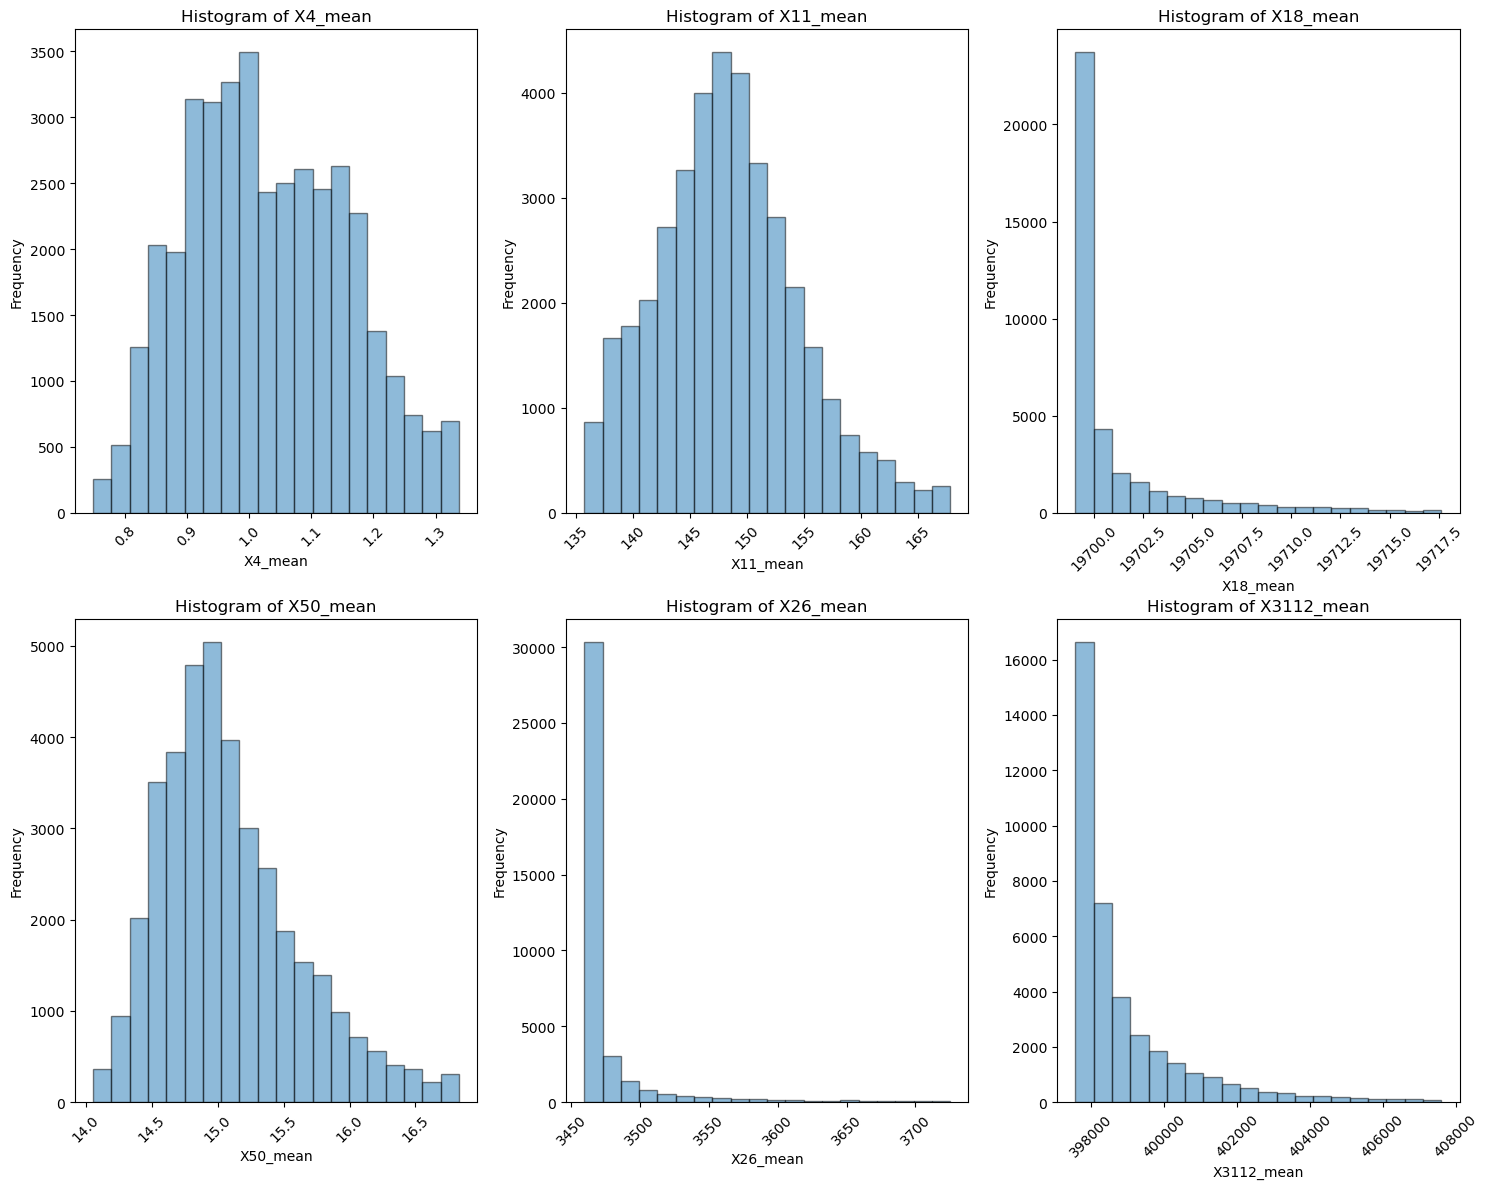

In [12]:
# Plot of distributions
X4 = train["X4_mean"]
X11 = train["X11_mean"]
X18 = train["X18_mean"]
X50 = train["X50_mean"]
X26 = train["X26_mean"]
X3112 = train["X3112_mean"]
Traits = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

import matplotlib.pyplot as plt

num_traits = len(Traits)

# Create a 3x2 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
axes = axes.flatten()  # Flatten the 3x2 array into a 1D array for easy iteration

for i, Trait in enumerate(Traits):
    ax = axes[i]
    ax.hist(train[Trait], bins=20, edgecolor='black', alpha=0.5)
    ax.set_title(f'Histogram of {Trait}')
    ax.set_xlabel(Trait)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45) 

    # Print summary statistics
    print(train[Trait].describe())

# Hide any empty subplots (if number of traits is less than 6)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
# Log Transforamtion
LOG_FEATURES = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

y_train = np.zeros_like(train[CONFIG.TARGET_COLUMNS], dtype=np.float32)
for target_idx, target in enumerate(CONFIG.TARGET_COLUMNS):
    v = train[target].values
    if target in LOG_FEATURES:
        v = np.log10(v)
    y_train[:, target_idx] = v

In [14]:
# Normalize input
X_SCALER = StandardScaler()
tabular_scaled = X_SCALER.fit_transform(tabular).astype(np.float32)
test_tabular_scaled = X_SCALER.transform(test_tabular).astype(np.float32)

Y_SCALER = StandardScaler()
y_train_scaled = Y_SCALER.fit_transform(y_train).astype(np.float32)

In [15]:
# Set image paths
print('JPEG Files Processing:')
train['file_path'] = train['id'].astype(str).apply(lambda x: f'./data/train_images/{x}.jpeg')
train['jpeg_bytes'] = train['file_path'].apply(lambda fp: open(fp, 'rb').read())
test['file_path'] = test['id'].astype(str).apply(lambda x: f'./data/test_images/{x}.jpeg')
test['jpeg_bytes'] = test['file_path'].apply(lambda fp: open(fp, 'rb').read())
print('JPEG Files Processing End')

JPEG Files Processing:
JPEG Files Processing End


In [16]:
CONFIG.N_TRAIN_SAMPLES = len(tabular_scaled)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.N_EPOCHS + 1

In [17]:
# Define data transformation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

TRAIN_TRANSFORMS = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedCrop(
        [112, 128],
        CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=0.75),
    A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, interpolation=3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.ImageCompression(quality_lower=85, quality_upper=100, p=0.3),
    A.ToFloat(),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
    ToTensorV2(),
])

TEST_TRANSFORMS = A.Compose([
    A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
    A.ToFloat(),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
    ToTensorV2(),
])

In [18]:
# Split train and test sets
train_idx = np.random.choice(len(train), int(0.9 * len(train)), replace=False)
test_idx = np.setdiff1d(np.arange(len(train)), train_idx)

train_images = train['jpeg_bytes'].values[train_idx]
train_tabular = tabular_scaled[train_idx]
train_y = y_train_scaled[train_idx]

val_images = train['jpeg_bytes'].values[test_idx]
val_tabular = tabular_scaled[test_idx]
val_y = y_train_scaled[test_idx]

test_images = test['jpeg_bytes'].values
test_tabular = test_tabular_scaled

In [19]:
# Define datasets and dataloaders
train_dataset = TrainDataset(
    train_images,
    train_tabular,
    train_y,
    TRAIN_TRANSFORMS
)

validation_dataset = TrainDataset(
    val_images,
    val_tabular,
    val_y,
    TEST_TRANSFORMS
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

test_dataset = TrainDataset(
    test['jpeg_bytes'].values,
    test_tabular,
    test['id'].values,
    TEST_TRANSFORMS,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

## Model Training

In [20]:
train_embedding = TrainDataset(
    train_images,
    train_tabular,
    train_y,
    TEST_TRANSFORMS
)

train_embedding_loader = DataLoader(
    train_embedding,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

image_encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg').to(device)
train_data = []
train_label = []
with torch.no_grad():
        for X_image, X_tabular, y_true in tqdm(train_embedding_loader):
            X_image = X_image.to(device)
            X_tabular = X_tabular.numpy()
            y_true = y_true.numpy()
            embedding = image_encoder(X_image).detach().cpu().numpy()
            X_combine = np.concatenate([X_tabular, embedding], axis=1)
            train_label.append(y_true)
            train_data.append(X_combine)

Using cache found in C:\Users\Kanade/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Kanade/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Kanade/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Kanade/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
INFO:dinov2:using SwiGLU layer as FFN


  0%|          | 0/541 [00:00<?, ?it/s]

In [26]:
train_data_combined = np.concatenate(train_data, axis=0)
train_label_combined = np.concatenate(train_label, axis=0)
train_label_combined = Y_SCALER.inverse_transform(train_label_combined)
train_label_combined = 10 ** train_label_combined

In [30]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

lgbm = MultiOutputRegressor(LGBMRegressor(
    objective='rmse',
    learning_rate=0.05,
    n_estimators=2000
    #max_bin=500,
    #num_leaves=1000,
    ))
lgbm.fit(train_data_combined, train_label_combined)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431037
[LightGBM] [Info] Number of data points in the train set: 34579, number of used features: 1699
[LightGBM] [Info] Start training from score 1.029685
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431037
[LightGBM] [Info] Number of data points in the train set: 34579, number of used features: 1699
[LightGBM] [Info] Start training from score 148.287397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431037
[LightGBM] [Info] Number of data points in the train set: 34579, number of used features: 1699
[LightGBM] [I

MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.05,
                                             n_estimators=2000,
                                             objective='rmse',
                                             random_state=42))

In [31]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

test_data = []

with torch.no_grad():
        for X_image, X_tabular, test_id in tqdm(test_dataloader):
            X_image = X_image.to(device)
            X_tabular = X_tabular.numpy()
            embedding = image_encoder(X_image).detach().cpu().numpy()
            X_combine = np.concatenate([X_tabular, embedding], axis=1)
            test_data.append(X_combine)

test_data_combined = np.concatenate(test_data, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
submission = pd.DataFrame({'id': test['id']})
submission[CONFIG.TARGET_COLUMNS] = 0
submission.columns = submission.columns.str.replace('_mean', '')

In [41]:
col_pred = lgbm.predict(test_data_combined)
for i, col in enumerate(CONFIG.TARGET_COLUMNS):
    submission[col.replace('_mean', '')] = col_pred[:, i]

submission.to_csv('submission.csv', index=False)

## Prepare for Submitting

In [37]:
# Reorder the submission_df
submission_df = pd.DataFrame(submission)
submission_df = submission_df[['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112']]
submission_df.to_csv('./submission.csv', index=False)
print("Done!")

Done!


In [39]:
submission_df.columns

Index(['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112'], dtype='object')

Reference: Modified bsaed on the Kaggle notebook: https://www.kaggle.com/code/riverfog7/efficientnet-image-tabular-eda-training#Model-Training---Pre; LoRA Github code: https://github.com/RobvanGastel/dinov2-finetune